expected scores :

- Accuracy: 0.9882119468148443
- Precision: 0.9948258020006899
- Recall: 0.9798691922194852
- F1 Score: 0.9872908554067356

# LSTM

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


data_train = pd.read_csv('./Dataset/KDDTrain+.txt', header=None)
data_train.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                      'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                      'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                      'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                      'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                      'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']


cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']


def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe


def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df


scaled_train = preprocess(data_train)


x = scaled_train.drop(['outcome', 'level'], axis=1).values
y = scaled_train['outcome'].values


pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}/n".format(x.shape[1], x_reduced.shape[1]))


y = y.astype('int')


x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)


model = Sequential()
model.add(LSTM(units=64, input_shape=(x_train.shape[1], 1), return_sequences=True)) 
model.add(Dropout(0.2))  
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32)) 
model.add(Dropout(0.2)) 
model.add(Dense(units=16, activation='relu'))  
model.add(Dense(units=1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train, epochs=20, batch_size=32,
                    validation_data=(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test), callbacks=[early_stopping])

Number of original features is 122 and of reduced features is 20/n
Epoch 1/20
3150/3150 [==============================] - 77s 22ms/step - loss: 0.1636 - accuracy: 0.9307 - val_loss: 0.0957 - val_accuracy: 0.9628
Epoch 2/20
3150/3150 [==============================] - 81s 26ms/step - loss: 0.0745 - accuracy: 0.9720 - val_loss: 0.0618 - val_accuracy: 0.9752
Epoch 3/20
3150/3150 [==============================] - 77s 24ms/step - loss: 0.0480 - accuracy: 0.9828 - val_loss: 0.0369 - val_accuracy: 0.9853
Epoch 4/20
3150/3150 [==============================] - 71s 23ms/step - loss: 0.0364 - accuracy: 0.9866 - val_loss: 0.0344 - val_accuracy: 0.9877
Epoch 5/20
3150/3150 [==============================] - 74s 23ms/step - loss: 0.0296 - accuracy: 0.9895 - val_loss: 0.0284 - val_accuracy: 0.9908
Epoch 6/20
3150/3150 [==============================] - 73s 23ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0500 - val_accuracy: 0.9846
Epoch 7/20
3150/3150 [==============================] - 7

788/788 [==============================] - 8s 8ms/step
Accuracy: 0.9932526294899782
Precision: 0.9932828841084942
Recall: 0.9922704493332201
F1 Score: 0.992776408600323


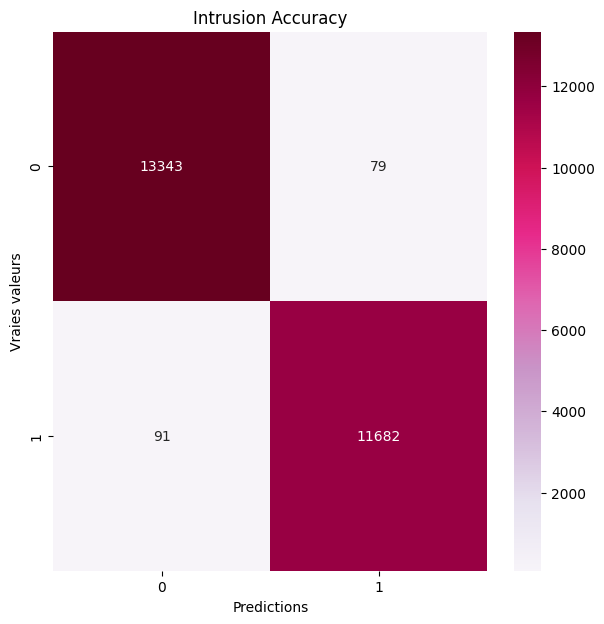

In [15]:
y_pred = model.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)))
y_pred = (y_pred > 0.5)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion, annot=True, cmap='PuRd', fmt='d')
plt.title('Intrusion Accuracy')
plt.xlabel('Predictions')
plt.ylabel('Vraies valeurs')
plt.show()

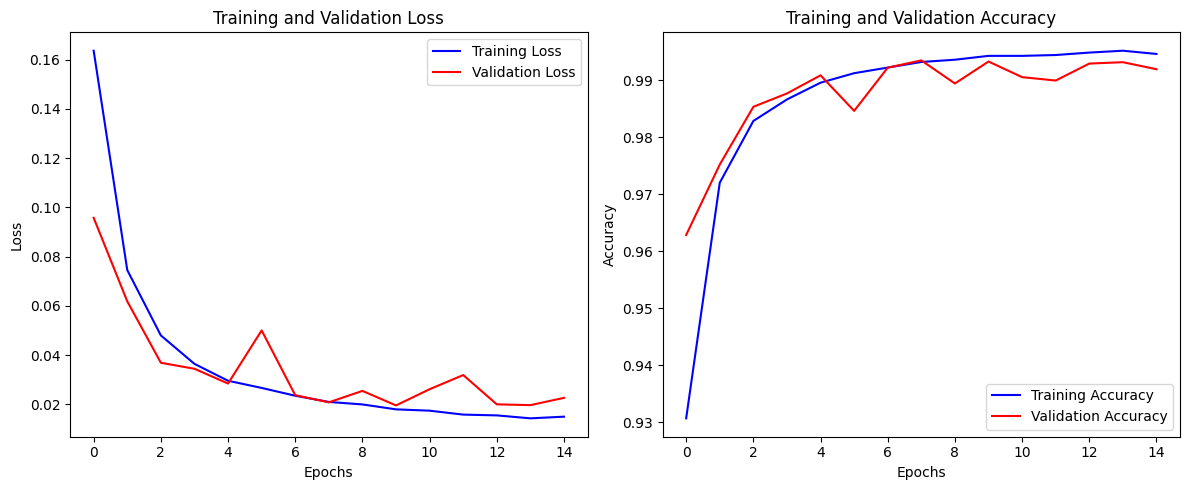

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.plot(loss, label='Training Loss', color='blue')
ax1.plot(val_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(accuracy, label='Training Accuracy', color='blue')
ax2.plot(val_accuracy, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()


plt.tight_layout()
plt.show()


# CNN + LSTM

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

data_train = pd.read_csv('./Dataset/KDDTrain+.txt', header=None)
data_train.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                      'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                      'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                      'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                      'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                      'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']


cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']


def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe


def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df


scaled_train = preprocess(data_train)


x = scaled_train.drop(['outcome', 'level'], axis=1).values
y = scaled_train['outcome'].values


pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))


y = y.astype('int')


x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)


model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, return_sequences=True))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(LSTM(units=32))
model.add(Dropout(0.2))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restoregbest_weights=True)


history2 = model2.fit(x_train, y_train, epochs=20, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


Number of original features is 122 and of reduced features is 20
Epoch 1/20
3150/3150 [==============================] - 54s 15ms/step - loss: 0.1045 - accuracy: 0.9559 - val_loss: 0.0748 - val_accuracy: 0.9693
Epoch 2/20
3150/3150 [==============================] - 42s 13ms/step - loss: 0.0523 - accuracy: 0.9802 - val_loss: 0.0391 - val_accuracy: 0.9864
Epoch 3/20
3150/3150 [==============================] - 42s 13ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.0328 - val_accuracy: 0.9888
Epoch 4/20
3150/3150 [==============================] - 43s 14ms/step - loss: 0.0273 - accuracy: 0.9904 - val_loss: 0.0234 - val_accuracy: 0.9928
Epoch 5/20
3150/3150 [==============================] - 42s 13ms/step - loss: 0.0227 - accuracy: 0.9925 - val_loss: 0.0229 - val_accuracy: 0.9918
Epoch 6/20
3150/3150 [==============================] - 44s 14ms/step - loss: 0.0210 - accuracy: 0.9930 - val_loss: 0.0218 - val_accuracy: 0.9924
Epoch 7/20
3150/3150 [==============================] - 41s

788/788 [==============================] - 7s 7ms/step
Accuracy: 0.9944433419329232
Precision: 0.995907579503794
Recall: 0.9921855092160027
F1 Score: 0.9940430601650923


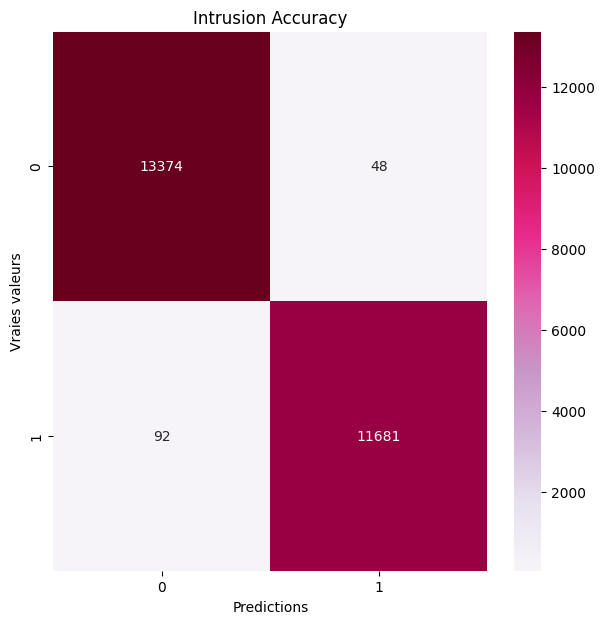

In [18]:
y_pred = model2.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)))
y_pred = (y_pred > 0.5)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion, annot=True, cmap='PuRd', fmt='d')
plt.title('Intrusion Accuracy')
plt.xlabel('Predictions')
plt.ylabel('Vraies valeurs')
plt.show()

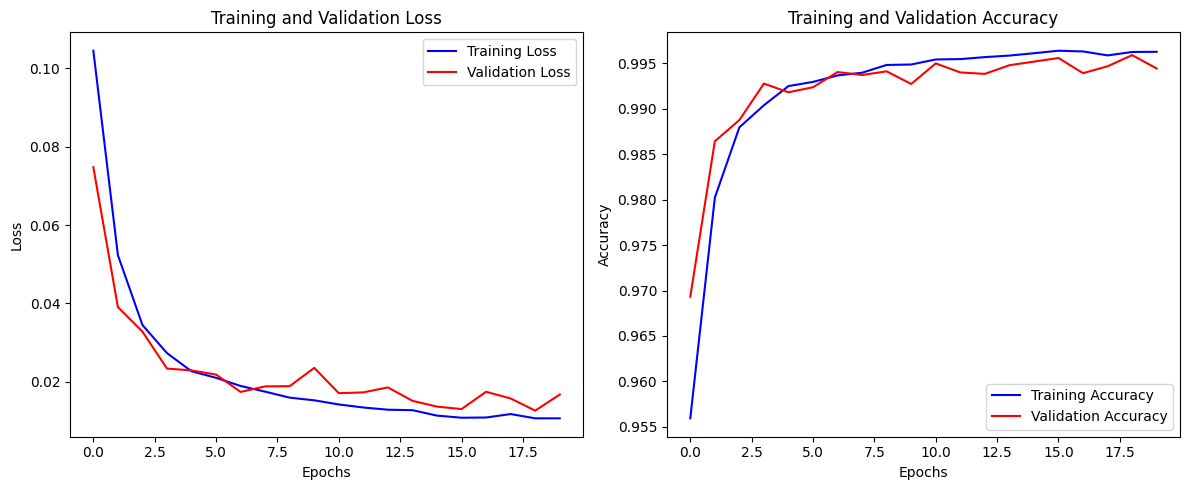

In [19]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']


accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.plot(loss, label='Training Loss', color='blue')
ax1.plot(val_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()


ax2.plot(accuracy, label='Training Accuracy', color='blue')
ax2.plot(val_accuracy, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()


plt.tight_layout()
plt.show()
